# Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules

import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: d

# Data

#### Load Ottawa Crime Data

In [2]:
df_ott_crime = pd.read_csv('Ottawa_crime_2018.csv')
df_ott_crime.head()

,Neighbourhood,Population Estimates (Year End),Crimes Against People (1000),Crimes Against Property (2000),Other Crimes (3000)
0,Bayshore - Belltown,9596,102,447.0,33.0
1,Beacon Hill South - Cardinal Heights,7293,46,150.0,12.0
2,Beaverbrook,6953,22,57.0,5.0
3,Beechwood Cemetery,0,1,NaN,NaN
4,Bells Corners East,5150,24,131.0,21.0


#### Setup Crime Data

In [3]:
# NaN to 0
df_ott_crime.fillna(0)

# rename columns
df_ott_crime = df_ott_crime.rename(columns={"Population Estimates (Year End)": "Population", "Crimes Against People (1000)": "Crimes Against People", "Crimes Against Property (2000)": "Crimes Against Property", "Other Crimes (3000)": "Other Crimes"})

# Delete columns where population is 0
df_ott_crime = df_ott_crime.drop(df_ott_crime[df_ott_crime["Population"].values == 0].index)

# multiply entries to get actual counts
df_ott_crime["Crimes Against People"] = df_ott_crime["Crimes Against People"].multiply(1000)
df_ott_crime["Crimes Against Property"] = df_ott_crime["Crimes Against Property"].multiply(2000)
df_ott_crime["Other Crimes"] = df_ott_crime["Other Crimes"].multiply(3000)


# remove decimals
df_ott_crime["Crimes Against Property"] = df_ott_crime["Crimes Against Property"].astype('int32')
df_ott_crime["Other Crimes"] = df_ott_crime["Other Crimes"].fillna(0)
df_ott_crime["Other Crimes"] = df_ott_crime["Other Crimes"].astype('int32')

# reset index
df_ott_crime.index = range(109)

df_ott_crime.head()

,Neighbourhood,Population,Crimes Against People,Crimes Against Property,Other Crimes
0,Bayshore - Belltown,9596,102000,894000,99000
1,Beacon Hill South - Cardinal Heights,7293,46000,300000,36000
2,Beaverbrook,6953,22000,114000,15000
3,Bells Corners East,5150,24000,262000,63000
4,Bells Corners West,4400,42000,222000,21000


#### Get Latitude and Longitude

In [78]:
search_address = df_ott_crime['Neighbourhood'].values.tolist()

geolocator = Nominatim(user_agent="ott_explorer")

df_lat_long = pd.DataFrame(columns = ['Neighbourhood', 'Latitude', 'Longitude'])

for N in search_address:    
    location = geolocator.geocode(N)
    if location == None or location.latitude > 45.450235 or location.latitude < 44.954140 or location.longitude > -75.197230 or location.longitude < -76.283615:
        if N.count('-') == 0:
            if N == "Hunt Club South Industrial":
                N = 'Colonnade'
                location = geolocator.geocode(N)
                lat = location.latitude
                long = location.longitude
                N = "Hunt Club South Industrial"
        else:
            n_list = N.split(' -')
            lat_list = []
            long_list = []
            for n in n_list:
                loc = geolocator.geocode(n)
                
                if N == "Bayshore - Belltown":
                    lat_list.append(45.2110)
                    long_list.append(-75.48146)
                elif N == "Braemar Park - Bel Air Heights - Copeland Park":
                    lat_list.append(45.21397)
                    long_list.append(-75.45063)
                elif N == "Convent Glen - Orléans Woods":
                    lat_list.append(45.28331)
                    long_list.append(-75.31391)
                elif N == "Emerald Woods - Sawmill Creek":
                    lat_list.append(45.20371)
                    long_list.append(-75.38416)
                elif N == "Hunt Club - Ottawa Airport":
                    lat_list.append(45.19454)
                    long_list.append(-75.39249)
                elif N == "Hunt Club East - Western Community":
                    lat_list.append(45.21228)
                    long_list.append(-75.40379)
                elif N == "Hunt Club Upper -Blossom Park - Timbermill":
                    lat_list.append(45.20354)
                    long_list.append(-75.38164)                        
                elif N == "Hawthorne Meadows - Sheffield Glen":
                    lat_list.append(45.396438)
                    long_list.append(-75.613864)                        
                elif N == "Glen Cairn - Kanata South Business Park":
                    lat_list.append(45.284745)
                    long_list.append(-75.88213)                 
                elif N == "Brookside - Briarbrook - Morgan's Grant":
                    lat_list.append(45.350027)
                    long_list.append(-75.938585)
                elif N == "Beacon Hill South - Cardinal Heights":
                    lat_list.append(45.441593)
                    long_list.append(-75.598855)
                elif N == "Borden Farm - Fisher Glen":
                    lat_list.append(45.353343)
                    long_list.append(-75.719124)
                elif N == "Briar Green - Leslie Park":
                    lat_list.append(45.336017)
                    long_list.append(-75.790128)                        
                elif N == "Carlingwood West - Glabar Park - McKellar Heights":
                    lat_list.append(45.369102)
                    long_list.append(-75.762857)
                elif N == "Hunt Club Woods - Quintarra - Revelstoke":
                    lat_list.append(45.353430)
                    long_list.append(-75.694505) 
                elif N == "Iris - Queensway Terrance South":
                    lat_list.append(45.353944)
                    long_list.append(-75.774042)
                elif N == "Kanata Lakes - Arcardia":
                    lat_list.append(45.308160)
                    long_list.append(-75.930676)
                elif N == "Ledbury - Heron Gate - Ridgemont":
                    lat_list.append(45.373612)
                    long_list.append(-75.655361)
                elif N == "Merivale Gardens - Grenfell Glen - Pineglen - Country Place":
                    lat_list.append(45.322555)
                    long_list.append(-75.728583)
                elif N == "Navan - Sarsfield":
                    lat_list.append(45.445709)
                    long_list.append(-75.347558)
                elif N == "Parkwood Hills - Stewart Farm":
                    lat_list.append(45.352981)
                    long_list.append(-75.718695)
                elif N == "Playfair Park - Lynda Park - Guildwood Estates":
                    lat_list.append(45.387648)
                    long_list.append(-75.644175)
                elif N == "Rideau Crest - Davidson Heights":
                    lat_list.append(45.279635)
                    long_list.append(-75.711531)
                elif N == "Rothwell Heights - Beacon Hill North":
                    lat_list.append(45.459232)
                    long_list.append(-75.621538)
                elif N == "Stonebridge - Halfmoon Bay - Heart's Desire":
                    lat_list.append(45.254138)
                    long_list.append(-75.732899)                        
                elif N == "Whitehaven - Queensway Terrace North":
                    lat_list.append(45.357139)
                    long_list.append(-75.786544)                           
                elif N == "Woodvale - Craig Henry - Manordale - Estates of Arlington Woods":
                    lat_list.append(45.332476)
                    long_list.append(-75.766440)                    
                elif N == "Crystal Bay - Lakeview Park":
                    lat_list.append(45.357338)
                    long_list.append(-75.866085)                      
                elif N == "Munster - Ashton":
                    lat_list.append(45.175104)
                    long_list.append(-75.976041) 
                else:
                    lat1 = loc.latitude
                    long1 = loc.longitude
                    if loc != None and lat1 < 45.450235 and lat1 > 44.954140 and long1 < -75.197230 and long1 > -76.283615:
                        lat_list.append(lat1)
                        long_list.append(long1)
                    
            lat = sum(lat_list)/len(lat_list)
            long = sum(long_list)/len(long_list)

    else:
        lat = location.latitude
        long = location.longitude
        
    df_lat_long.loc[len(df_lat_long)] = [N,lat,long]
    
df_lat_long

,Neighbourhood,Latitude,Longitude
0,Bayshore - Belltown,45.211000,-75.481460
1,Beacon Hill South - Cardinal Heights,45.441593,-75.598855
2,Beaverbrook,45.441593,-75.598855
3,Bells Corners East,45.318996,-75.829691
4,Bells Corners West,45.318996,-75.829691
5,Billings Bridge - Alta Vista,45.387521,-75.675305
6,Blackburn Hamlet,45.431968,-75.564280
7,Borden Farm - Fisher Glen,45.353343,-75.719124
8,Braemar Park - Bel Air Heights - Copeland Park,45.213970,-75.450630
9,Briar Green - Leslie Park,45.336017,-75.790128


#### Combine Lat/Long and Crime Data Into Single DataFrame

In [79]:
df_comb = df_ott_crime
df_comb['Latitude'] = ''
df_comb['Longitude'] = ''

for n in range(df_comb['Neighbourhood'].size):    
    nbrhd = df_comb[df_comb['Neighbourhood'] == df_lat_long['Neighbourhood'].values[n]].index[0]    
    df_comb['Latitude'].values[nbrhd] = df_lat_long['Latitude'].values[n]    
    df_comb['Longitude'].values[nbrhd] = df_lat_long['Longitude'].values[n]
df_comb

,Neighbourhood,Population,Crimes Against People,Crimes Against Property,Other Crimes,Latitude,Longitude,Distance,Neighborhood Safety Scale
0,Bayshore - Belltown,9596,102000,894000,99000,45.211,-75.4815,975.87,114
1,Beacon Hill South - Cardinal Heights,7293,46000,300000,36000,45.4416,-75.5989,369.567,52
2,Beaverbrook,6953,22000,114000,15000,45.4416,-75.5989,369.567,21
3,Bells Corners East,5150,24000,262000,63000,45.319,-75.8297,4.09758,67
4,Bells Corners West,4400,42000,222000,21000,45.319,-75.8297,4.09758,64
5,Billings Bridge - Alta Vista,12987,143000,1054000,144000,45.3875,-75.6753,2.79439,103
6,Blackburn Hamlet,8989,41000,176000,36000,45.432,-75.5643,2.79439,28
7,Borden Farm - Fisher Glen,8522,33000,308000,57000,45.3533,-75.7191,2.79439,46
8,Braemar Park - Bel Air Heights - Copeland Park,7088,28000,230000,39000,45.214,-75.4506,2.79439,41
9,Briar Green - Leslie Park,4450,14000,146000,3000,45.336,-75.7901,2.79439,36


#### Get FourSquare Police Station Locations

In [6]:
venues_list=[]

CLIENT_ID = '2OP0SEDBNULXB2X2THYSY1IGIDCHCRLKAG0PN22T0YOOG3BH' #2OP0SEDBNULXB2X2THYSY1IGIDCHCRLKAG0PN22T0YOOG3BH #MH155IV1NTNEQJTNXMNLNFY44CZQMCJZEYGKHULOJLDQ2OYF
CLIENT_SECRET = 'GIFU52U5QOOC2IXP43KIXB43LEVOVTPULPMZNFZ3W21HKFB4'#GIFU52U5QOOC2IXP43KIXB43LEVOVTPULPMZNFZ3W21HKFB4 #OVYTXGK3WMKCJIELO3M5PHV24S1MTYLQM0QCPEPYMW3IVIPY
VERSION = '20180605' 

url = 'https://api.foursquare.com/v2/venues/explore?&categoryId=4bf58dd8d48988d12e941735&client_id={}&client_secret={}&v={}&ll=45.4215,-75.6972&radius=90000&limit=100'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
# make the GET request
results = requests.get(url).json()["response"]['groups'][0]['items']
# return only relevant information for each nearby venue
venues_list.append([( 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

nearby_police_station = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
nearby_police_station.columns = [
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']

nearby_police_station

,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ottawa Police Service,45.412698,-75.686137,Police Station
1,Ottawa Police Association,45.410197,-75.690723,Police Station
2,Service de Police de Gatineau,45.451847,-75.730310,Police Station
3,Ville Gatineau - Secteur Hull,45.451808,-75.730888,Police Station
4,Ottawa Police Services Records Management Serv...,45.352839,-75.785340,Police Station
5,Police Station,45.325883,-75.779134,Police Station
6,RCMP National Headquarters,45.295531,-75.705378,Police Station
7,Ontario Provincial Police (OPP),45.322122,-75.887195,Police Station
8,Ottawa Police Services,45.293388,-75.926355,Police Station
9,customs,44.724037,-75.436569,Police Station


In [80]:
# Delete Stations Outside of Ottawa 
nearby_police_station2 = nearby_police_station.drop(nearby_police_station[nearby_police_station["Venue Longitude"].values < -76.283615].index)
nearby_police_station2.index = range(len(nearby_police_station2.index.values))
nearby_police_station2 = nearby_police_station2.drop(nearby_police_station2[nearby_police_station2["Venue Longitude"].values > -75.197230].index)
nearby_police_station2.index = range(len(nearby_police_station2.index.values))
nearby_police_station2 = nearby_police_station2.drop(nearby_police_station2[nearby_police_station2["Venue Latitude"].values > 45.450235].index)
nearby_police_station2.index = range(len(nearby_police_station2.index.values))
nearby_police_station2 = nearby_police_station2.drop(nearby_police_station2[nearby_police_station2["Venue Latitude"].values < 44.954140].index)
nearby_police_station2.index = range(len(nearby_police_station2.index.values))

# Delete non-police station entries
nearby_police_station2 = nearby_police_station2[nearby_police_station2['Venue'].str.contains('Ottawa')]
nearby_police_station2 = nearby_police_station2.drop(nearby_police_station2[nearby_police_station2['Venue'].str.contains('Records')].index)
nearby_police_station2.index = range(len(nearby_police_station2.index.values))

# Delete unnecessary columns and rename columns
nearby_police_station2 = nearby_police_station2.drop(columns=['Venue', 'Venue Category'])
nearby_police_station2 = nearby_police_station2.rename(columns={"Venue Latitude": "Latitude","Venue Longitude": "Longitude"})
nearby_police_station2

,Latitude,Longitude
0,45.412698,-75.686137
1,45.410197,-75.690723
2,45.293388,-75.926355


In [81]:
# Add missing stations
stations_list = ['211 Huntmar, Ottawa, Ontario', '474 Elgin, Ottawa, Ontario', '3343 St.Joseph, Ottawa, Ontario', '4561 Bank St, Ottawa, Ontario', '245 Bank St, Ottawa, Ontario', '245 Greenbank Rd, Nepean, Ontario', '3343 St Joseph Blvd, Orléans, Ontario']
stations_ll = []
for s in stations_list:
    location = geolocator.geocode(s)
    stations_ll.append([location.latitude,location.longitude])
stations_ll_df = pd.DataFrame(stations_ll, columns=['Latitude', 'Longitude'])
stations_ll_df

,Latitude,Longitude
0,45.293262,-75.926948
1,45.412526,-75.686295
2,45.473835,-75.518817
3,45.330681,-75.598948
4,45.416459,-75.697143
5,45.325651,-75.778287
6,45.484222,-75.500403


In [82]:
police_stations_all = nearby_police_station2.append(stations_ll_df)
police_stations_all.index = range(len(police_stations_all.index.values))
police_stations_all

,Latitude,Longitude
0,45.412698,-75.686137
1,45.410197,-75.690723
2,45.293388,-75.926355
3,45.293262,-75.926948
4,45.412526,-75.686295
5,45.473835,-75.518817
6,45.330681,-75.598948
7,45.416459,-75.697143
8,45.325651,-75.778287
9,45.484222,-75.500403


#### Calculate distance and Add to DataFrame

In [83]:
import geopy.distance
df_comb['Distance'] = ''
dist_list = []
for a in range(df_comb['Neighbourhood'].size): 
    lat_long_1 = (df_comb['Latitude'].values[a],df_comb['Longitude'].values[a])    
    for l_l in range(police_stations_all['Latitude'].size):
        ps_lat_long = (police_stations_all['Latitude'].values[l_l], police_stations_all['Longitude'].values[l_l]) 
        dist_list.append(geopy.distance.distance(lat_long_1, ps_lat_long))
    
    df_comb['Distance'].values[a] = float(str(min(dist_list)).replace(' km', ''))
df_comb

,Neighbourhood,Population,Crimes Against People,Crimes Against Property,Other Crimes,Latitude,Longitude,Distance,Neighborhood Safety Scale
0,Bayshore - Belltown,9596,102000,894000,99000,45.211,-75.4815,16.184,114
1,Beacon Hill South - Cardinal Heights,7293,46000,300000,36000,45.4416,-75.5989,7.2133,52
2,Beaverbrook,6953,22000,114000,15000,45.4416,-75.5989,7.2133,21
3,Bells Corners East,5150,24000,262000,63000,45.319,-75.8297,4.09758,67
4,Bells Corners West,4400,42000,222000,21000,45.319,-75.8297,4.09758,64
5,Billings Bridge - Alta Vista,12987,143000,1054000,144000,45.3875,-75.6753,2.79439,103
6,Blackburn Hamlet,8989,41000,176000,36000,45.432,-75.5643,2.79439,28
7,Borden Farm - Fisher Glen,8522,33000,308000,57000,45.3533,-75.7191,2.79439,46
8,Braemar Park - Bel Air Heights - Copeland Park,7088,28000,230000,39000,45.214,-75.4506,2.79439,41
9,Briar Green - Leslie Park,4450,14000,146000,3000,45.336,-75.7901,1.47945,36


#### Calculate neighborhood safety scale

In [84]:
df_comb['Neighborhood Safety Scale'] = ''
for n in range(df_comb['Neighbourhood'].size):     
    df_comb['Neighborhood Safety Scale'].values[n] = (df_comb['Crimes Against People'].values[n] + df_comb['Crimes Against Property'].values[n] + df_comb['Other Crimes'].values[n] + df_comb['Distance'].values[n]) / df_comb['Population'].values[n] 
df_comb

,Neighbourhood,Population,Crimes Against People,Crimes Against Property,Other Crimes,Latitude,Longitude,Distance,Neighborhood Safety Scale
0,Bayshore - Belltown,9596,102000,894000,99000,45.211,-75.4815,16.184,114.112
1,Beacon Hill South - Cardinal Heights,7293,46000,300000,36000,45.4416,-75.5989,7.2133,52.38
2,Beaverbrook,6953,22000,114000,15000,45.4416,-75.5989,7.2133,21.7183
3,Bells Corners East,5150,24000,262000,63000,45.319,-75.8297,4.09758,67.7678
4,Bells Corners West,4400,42000,222000,21000,45.319,-75.8297,4.09758,64.7737
5,Billings Bridge - Alta Vista,12987,143000,1054000,144000,45.3875,-75.6753,2.79439,103.257
6,Blackburn Hamlet,8989,41000,176000,36000,45.432,-75.5643,2.79439,28.1458
7,Borden Farm - Fisher Glen,8522,33000,308000,57000,45.3533,-75.7191,2.79439,46.703
8,Braemar Park - Bel Air Heights - Copeland Park,7088,28000,230000,39000,45.214,-75.4506,2.79439,41.9022
9,Briar Green - Leslie Park,4450,14000,146000,3000,45.336,-75.7901,1.47945,36.6295


# Explore the Data

#### List of Top 10 Safest Neighborhoods

In [85]:
df_comb['Neighborhood Safety Scale'] = df_comb['Neighborhood Safety Scale'].astype('int32')
df_safest = df_comb.sort_values(by='Neighborhood Safety Scale', ascending=True)
df_safest.head(10)

,Neighbourhood,Population,Crimes Against People,Crimes Against Property,Other Crimes,Latitude,Longitude,Distance,Neighborhood Safety Scale
34,Dunrobin,6559,7000,86000,3000,45.3573,-75.8661,0.224007,14
10,Bridlewood - Emerald Meadows,25404,65000,316000,48000,45.2727,-75.8501,1.47945,16
31,Corkery,3901,13000,50000,12000,45.2833,-75.3139,0.224007,19
74,Old Barrhaven West,20397,53000,322000,39000,45.2795,-75.763,0.224007,20
69,Metcalfe,6417,15000,106000,9000,45.3226,-75.7286,0.224007,20
70,Munster - Ashton,4966,14000,56000,33000,45.1751,-75.976,0.224007,20
23,Chapel Hill North,10249,28000,160000,27000,45.4163,-75.6943,0.224007,20
2,Beaverbrook,6953,22000,114000,15000,45.4416,-75.5989,7.2133,21
33,Cumberland,4324,12000,78000,3000,45.3573,-75.8661,0.224007,21
41,Fitzroy,4289,6000,86000,0,45.2037,-75.3842,0.224007,21


#### Chromo Map

In [91]:
ott_geo = r'Ottawa_Neighbourhoods.geojson'

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(df_comb['Neighborhood Safety Scale'].min(),
                              df_comb['Neighborhood Safety Scale'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# let Folium determine the scale.
world_map = folium.Map(location=[45.3, -75.7], zoom_start=10)
world_map.choropleth(
    geo_data=ott_geo,
    data=df_safest,
    columns=['Neighbourhood', 'Neighborhood Safety Scale'],
    key_on='feature.properties.Name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Neighborhood Safety',
    reset=True
)
#folium.LayerControl().add_to(world_map)
world_map

#### Bar Chart of Top 10 Safest Neighborhoods

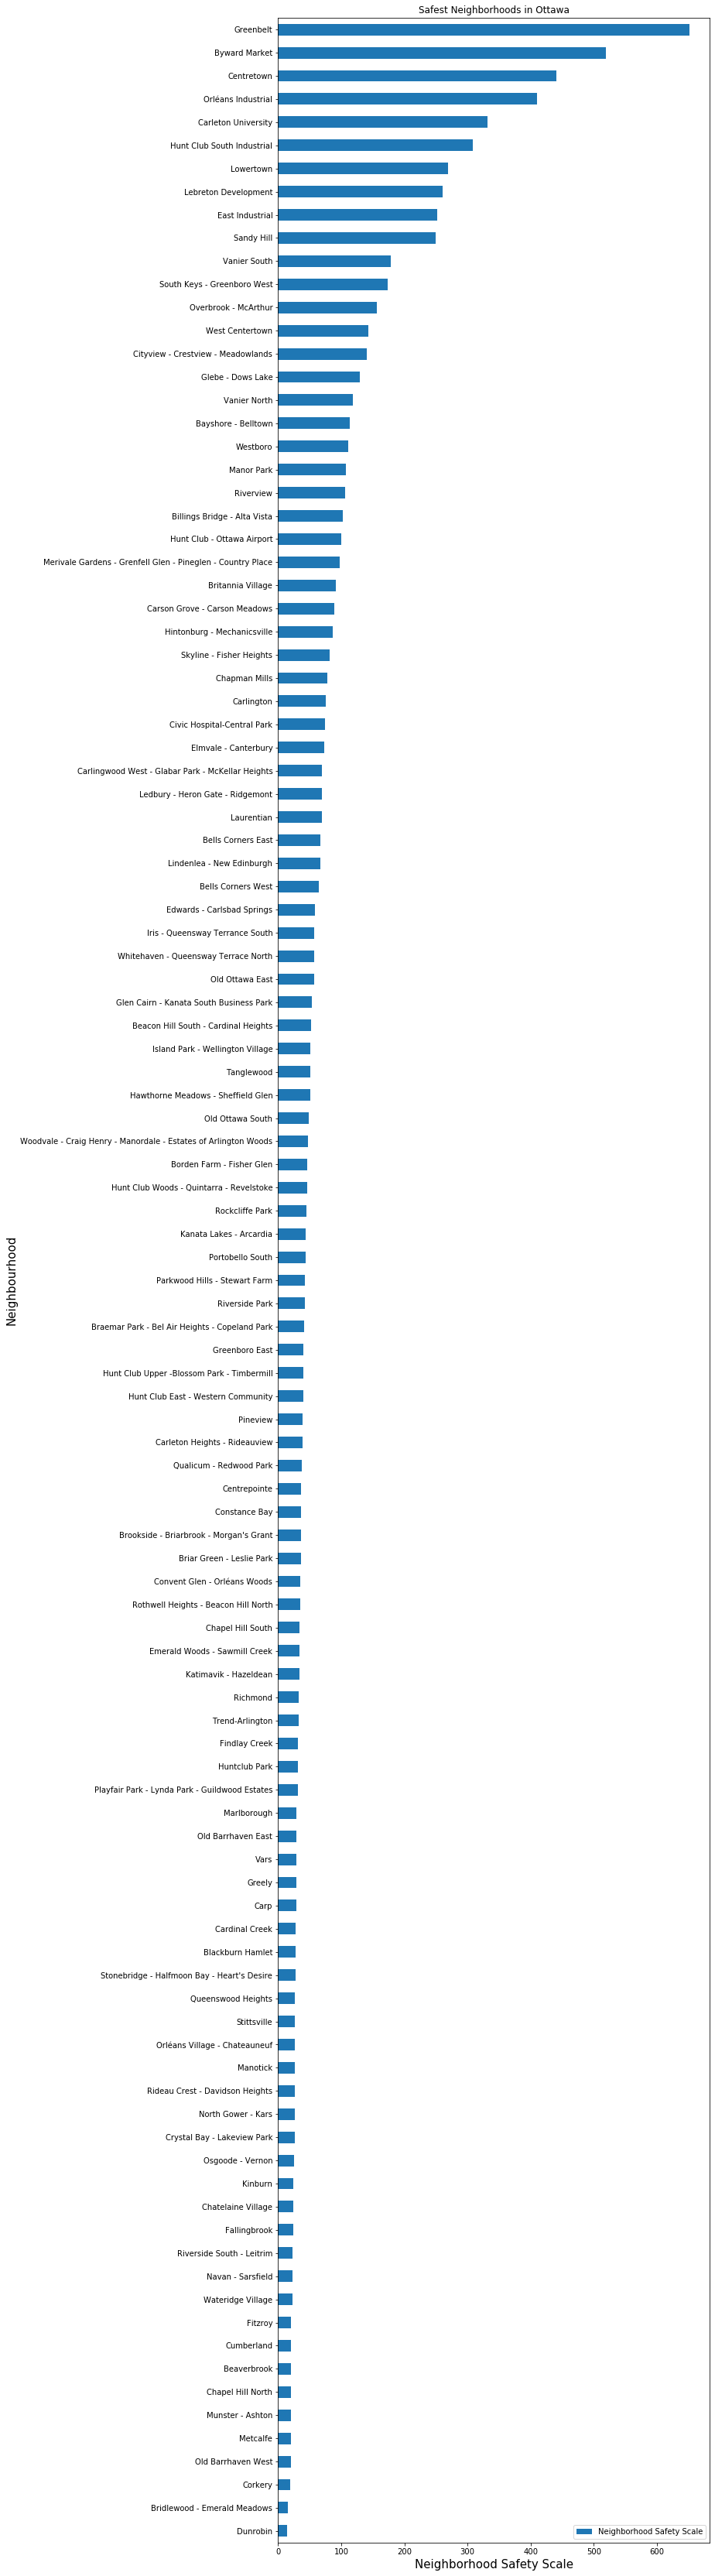

In [90]:
import matplotlib as mpl
import matplotlib.pyplot as plt

df_nss = df_comb.drop(columns=['Population','Crimes Against People', 'Crimes Against Property', 'Other Crimes', 'Latitude','Longitude', 'Distance'])
df_nss = df_nss.sort_values(by='Neighborhood Safety Scale', ascending=True)

df_nss.plot(kind='barh', x='Neighbourhood', y='Neighborhood Safety Scale', figsize=(10, 60), fontsize=10)

plt.xlabel('Neighborhood Safety Scale', fontsize=15) # add to x-label to the plot
plt.ylabel('Neighbourhood', fontsize=15) # add y-label to the plot
plt.title('Safest Neighborhoods in Ottawa') # add title to the plot

plt.show()